In [9]:
scanpath="/home/michele/Desktop/Colombo/Scannet/scans/scene0002_00/"

In [ ]:
import pandas as pd

# Load your mapping file (tab-separated)
df = pd.read_csv(scanpath+"scannetv2-labels.combined.tsv", sep="\t")

# Create id to class name mapping (e.g., from `id` to `nyuClass` or `category`)
id_to_name = dict(zip(df["nyu40id"], df["nyuClass"]))  # or "nyuClass"


In [6]:
len(id_to_name)

40

In [10]:
import imageio

label = imageio.v2.imread(scanpath+"label_nyu40/0.png")

# Get unique class IDs in the label image
unique_classes = set(label.flatten())

for cls_id in sorted(unique_classes):
    print(f"Class {cls_id}: {id_to_name.get(cls_id, 'Unknown')}")

Class 0: Unknown
Class 1: wall
Class 2: floor
Class 3: cabinet
Class 5: chair
Class 6: sofa
Class 8: door
Class 18: pillow
Class 39: nan
Class 40: cup


# Creating folder structure for training

In [14]:
import os
import shutil
import random
from pathlib import Path


rgb_dir=scanpath+"color"         # Folder with .jpg images
label_dir=scanpath+"label_nyu40"     # Folder with .png grayscale masks
output_dir="output_db"         # Output dataset folder
train_pct=0.7
val_pct=0.2
test_pct=0.1


rgb_dir = Path(rgb_dir)
label_dir = Path(label_dir)
output_dir = Path(output_dir)

# Get matching image/label file names
image_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(".jpg")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

assert len(image_files) == len(label_files), "Number of images and labels must match"
assert all(os.path.splitext(i)[0] == os.path.splitext(l)[0] for i, l in zip(image_files, label_files)), "Filenames don't match"

# Shuffle consistently
paired = list(zip(image_files, label_files))
random.shuffle(paired)

n_total = len(paired)
n_train = int(train_pct * n_total)
n_val = int(val_pct * n_total)

train_set = paired[:n_train]
val_set = paired[n_train:n_train+n_val]
test_set = paired[n_train+n_val:]

splits = {
    "train": train_set,
    "val": val_set,
    "test": test_set
}

# Create directory structure
for subfolder in ["images", "labels"]:
    for split in splits:
        path = output_dir / subfolder / split
        path.mkdir(parents=True, exist_ok=True)

# Copy files
for split, items in splits.items():
    for img_name, lbl_name in items:
        shutil.copy(rgb_dir / img_name, output_dir / "images" / split / img_name)
        shutil.copy(label_dir / lbl_name, output_dir / "labels" / split / lbl_name)

print(f"✅ Split complete! {n_total} files -> {n_train} train, {n_val} val, {len(test_set)} test.")
   


✅ Split complete! 5193 files -> 3635 train, 1038 val, 520 test.


# Train

In [5]:
import torch

print("Torch version:", torch.__version__)
print("CUDA disponibile:", torch.cuda.is_available())
print("Versione CUDA supportata da PyTorch:", torch.version.cuda)
print("Numero di GPU:", torch.cuda.device_count())
print("Nome GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Nessuna GPU trovata")
print("Dispositivo corrente:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")


Torch version: 1.9.0+cu111
CUDA disponibile: True
Versione CUDA supportata da PyTorch: 11.1
Numero di GPU: 1
Nome GPU: NVIDIA GeForce GTX 1050 Ti
Dispositivo corrente: 0


In [7]:

torch.cuda.empty_cache()       # Clears unused memory from the GPU cache
torch.cuda.ipc_collect()       # Collects inter-process memory (useful if you're restarting processes)

In [8]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

# ==== Config Parameters ====
EPOCHS = 20
BATCH_SIZE = 4
PATIENCE = 5
IMAGE_SIZE =  (480, 640)  # (Height, Width)

# ==== Custom Dataset ====
class NYU40SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.labels = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])
        self.transform = transform

        assert len(self.images) == len(self.labels), "Mismatch in image and label count"
        assert all(os.path.splitext(i)[0] == os.path.splitext(l)[0] for i, l in zip(self.images, self.labels)), "Mismatch in filenames"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.image_dir / self.images[idx]
        label_path = self.label_dir / self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        image = self.transform(image) if self.transform else T.ToTensor()(image)
        label = torch.from_numpy(np.array(label)).long()

        return image, label

# ==== Transforms ====
transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor()
])

# ==== Paths ====
root = Path("output_db")
train_dataset = NYU40SegmentationDataset(root / "images/train", root / "labels/train", transform)
val_dataset   = NYU40SegmentationDataset(root / "images/val", root / "labels/val", transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==== Model ====
NUM_CLASSES = 40  # NYU40
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.cuda()

# ==== Loss and Optimizer ====
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==== Training with Early Stopping ====
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model(imgs)['out']

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)['out']
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"🔍 Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "deeplabv3_nyu40.pth")
        print("💾 Model improved. Saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("✅ Training complete.")


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.66 GiB already allocated; 29.00 MiB free; 2.67 GiB reserved in total by PyTorch)

In [ ]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load the test set
test_dataset = NYU40SegmentationDataset(root / "images/test", root / "labels/test", transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Put the model in eval mode
model.eval()

# Inference loop
with torch.no_grad():
    for idx, (img, label) in enumerate(test_loader):
        img = img.cuda()
        output = model(img)['out']
        pred = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

        # Save or visualize the prediction
        pred_image = Image.fromarray(pred.astype(np.uint8))
        pred_image.save(f"predictions/test_{idx}.png")

        # Optional: save original RGB for comparison
        TF.to_pil_image(img.cpu().squeeze()).save(f"predictions/test_{idx}_rgb.jpg")

        if idx < 5:  # display a few examples
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(TF.to_pil_image(img.cpu().squeeze()))
            plt.title("RGB")

            plt.subplot(1,3,2)
            plt.imshow(label.squeeze().cpu(), cmap="gray")
            plt.title("Ground Truth")

            plt.subplot(1,3,3)
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")

            plt.show()


# FROM CHECKPOINT

In [3]:
import torch
import torchvision

In [4]:

def strip_prefix(state_dict, prefix):
    return {
        (k[len(prefix):] if k.startswith(prefix) else k): v
        for k, v in state_dict.items()
    }
model = torchvision.models.segmentation.deeplabv3_resnet101(
        pretrained=False,
        pretrained_backbone=True,
        progress=True,
        num_classes=40,
        aux_loss=None,
    )
checkpoint = torch.load("best-epoch143-step175536.ckpt")
# If checkpoint is a state_dict directly
checkpoint = checkpoint["state_dict"]
# remove any aux classifier stuff
removekeys = [
    key for key in checkpoint.keys()
    if key.startswith("_model._model.aux_classifier")
]
print(removekeys)
for key in removekeys:
    del checkpoint[key]
checkpoint = strip_prefix(checkpoint, "_model._model.")
try:
    model.load_state_dict(checkpoint, strict=True)
except RuntimeError as e:
    print(e)
model.load_state_dict(checkpoint, strict=False)

['_model._model.aux_classifier.0.weight', '_model._model.aux_classifier.1.weight', '_model._model.aux_classifier.1.bias', '_model._model.aux_classifier.1.running_mean', '_model._model.aux_classifier.1.running_var', '_model._model.aux_classifier.1.num_batches_tracked', '_model._model.aux_classifier.4.weight', '_model._model.aux_classifier.4.bias']


<All keys matched successfully>

In [5]:
for k in list(checkpoint.keys()):
    print(k)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.bn1.running_mean
backbone.bn1.running_var
backbone.bn1.num_batches_tracked
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.bn1.running_mean
backbone.layer1.0.bn1.running_var
backbone.layer1.0.bn1.num_batches_tracked
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.bn2.running_mean
backbone.layer1.0.bn2.running_var
backbone.layer1.0.bn2.num_batches_tracked
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.bn3.running_mean
backbone.layer1.0.bn3.running_var
backbone.layer1.0.bn3.num_batches_tracked
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.0.downsample.1.running_mean
backbone.layer1.0.downsample.1.running_var
backbone.layer1.0.downsample.1.num_batches_tracked
backbone.lay

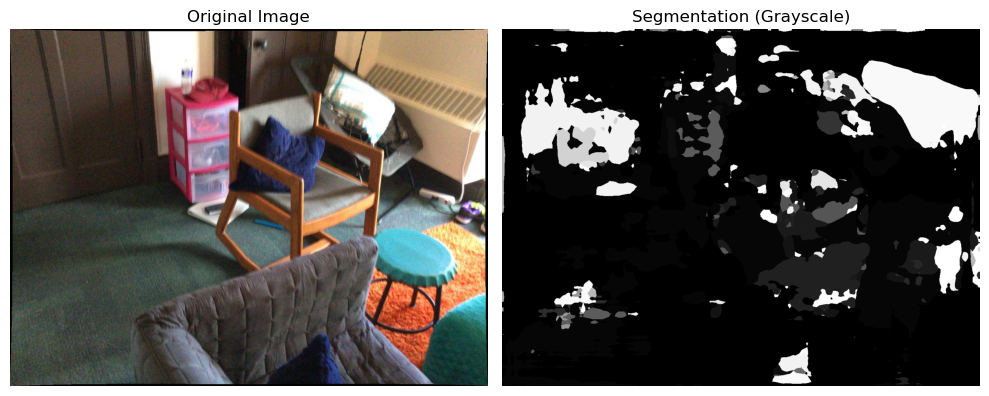

In [15]:
# 2. Preprocess
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225]),   # ImageNet std
])
input_tensor = preprocess(image).unsqueeze(0)  # Shape: [1, 3, H, W]

# 3. Move model & input to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_tensor = input_tensor.to(device)
model.eval()

# 4. Inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # Shape: [40, H, W]
    prediction = output.argmax(0).cpu()     # Shape: [H, W], values 0-39

# 5. Plot grayscale segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentation (Grayscale)")
plt.imshow(prediction, cmap='gray', vmin=0, vmax=39)
plt.axis("off")

plt.tight_layout()
plt.show()